# Number of atomic orbitals for molecules in the SPICE dataset

This notebook computes a histogram of the number of atomic orbitals for the molecules in the SPICE data set using the `def2-TZVPPD` basis set.

To reduce the computation time, one out of every ten molecules is sampled from the dataset. The computation is then distributed over a number of parallel processes.

For each molecule, only the first conformation is used out of the several listed in the dataset.

NOTE: the notebook expects the file `SPICE-1.1.4.hdf5` under `notebooks`. The dataset can be downloaded with the following command:
```
wget https://zenodo.org/record/8222043/files/SPICE-1.1.4.hdf5?download=1
```
Be patient as it is a 16GB file.

In [1]:
!pip install h5py mendeleev

In [2]:
import h5py
import numpy as np
import pyscf
import mendeleev
import tqdm
import itertools
from matplotlib import pyplot as plt
import multiprocessing

In [3]:
f = h5py.File("./SPICE-1.1.4.hdf5")

In [4]:
print(f"The dataset contains {len(f)} molecules")

The dataset contains 19238 molecules


The next cell computes the number of atomic orbitals for the specified basis set for each compound in the SPICE data.


In [5]:
def build_mol(mol_str, basis_name):
    mol = pyscf.gto.mole.Mole()
    mol.build(atom=mol_str, unit="Angstrom", basis=basis_name, spin=0, verbose=0)
    return mol

def get_mol_str_list_spice(f, entry="trp", conformation=0, conv_fact=1.0):
    mol = f[entry]
    return list(
        zip(
            (mendeleev.element(int(n)).symbol for n in mol['atomic_numbers']),
            mol['conformations'][conformation])
    )

nao_nrs = []

def compute_nao_nr(entry):
    mol_str = get_mol_str_list_spice(f,entry)
    try:
        return build_mol(mol_str, basis_name="def2-TZVPPD").nao_nr()
    except RuntimeError:    # ions are not handled
        return np.nan

sampling_factor = 10

with multiprocessing.Pool(processes=32) as p:
    nao_nrs = list(tqdm.tqdm(
        p.imap_unordered(compute_nao_nr, itertools.islice(f, None, None, sampling_factor)),
        total=int(len(f)/10), ncols=120
        ))


1924it [06:25,  4.99it/s]                                                                                               


In [6]:
nao_nrs = np.array(nao_nrs)

In [7]:
nao_nrs

array([ 429.,  735.,   nan, ..., 1396., 1490., 2171.])

In [8]:
failed_count = np.sum(np.isnan(nao_nrs))
print(f"build_mol() failed on {failed_count} molecules out of {failed_count+len(nao_nrs)}")

build_mol() failed on 173 molecules out of 2097


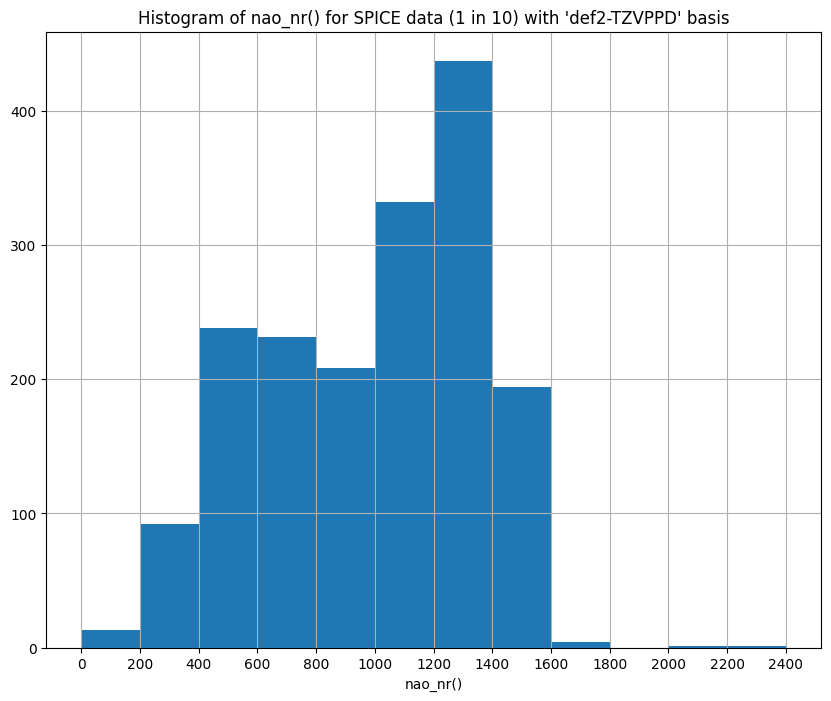

In [9]:
bins = np.linspace(0,2400,13)
plt.figure(figsize=(10,8))
plt.hist(nao_nrs, bins=bins)
plt.xlabel("nao_nr()")
plt.xticks(bins)
plt.grid()
plt.title("Histogram of nao_nr() for SPICE data (1 in 10) with 'def2-TZVPPD' basis");


In [10]:
print(f"Within the present sample of molecules, the maximum number of atomic orbital is {max(nao_nrs)}")

Within the present sample of molecules, the maximum number of atomic orbital is 2273.0


Let's have a look at one of the entries of the dataset

In [11]:
entry = "val-met"
mol_str = get_mol_str_list_spice(f, entry=entry)

In [12]:
m = build_mol(mol_str, basis_name="def2-TZVPPD")
m.nao_nr()

1188

In [13]:
build_mol(mol_str, basis_name="sto-3g").nao_nr()

129

`def2-TZVPPD` results in >9x the `sto-3g` orbitals.

Let's see what happens if one tries to compute the ERIs with the 8-fold symmetry accounted for.

In [14]:
ERI = m.intor("int2e_sph", aosym="s8")

MemoryError: Unable to allocate 1.81 TiB for an array with shape (249406184511,) and data type float64

Let's check the shape of the output tensor and the size of the array

In [15]:
(249_406_184_511 * 8)**0.25

1188.5003155235786

In [16]:
f"{249_406_184_511 * 8:,d}"

'1,995,249,476,088'

As an aside, let's check in what units the coordinates are given in the conformations. Let's compute the minimum interatomic distance for the molecule. It should be around 90pm, 0.9 angstrom, the length of the O-H bond. 

In [17]:
import operator

def min_interatomic_distance(mol_str):
    """This computes the minimum distance between atoms."""
    coords = map(operator.itemgetter(1), mol_str) 
    distances = map(
        lambda x: np.linalg.norm(x[0] - x[1]),
        itertools.combinations(coords, 2)
        )
    return min(distances)

In [18]:
min_interatomic_distance(mol_str=mol_str)

1.844831

This value of the minimum interatomic distance suggests that the unit for the coordinates in the conformations is `bohr`.
